Tahmin Edilen Sınıf: Angry


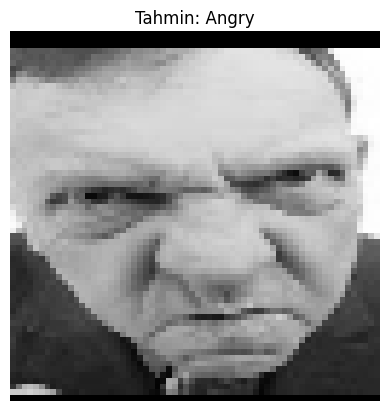

In [12]:
import os
import cv2
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from skimage.feature import hog

# Cihaz ayarı: GPU varsa kullanılır, yoksa CPU kullanılır.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DeepCNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(DeepCNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn5   = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(128 * 8 * 8, 256)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        features = self.fc(x)
        return features

def extract_hog_features(image):
    image = np.float32(image) / 255.0
    return hog(image, orientations=9, pixels_per_cell=(8,8),
               cells_per_block=(2,2), block_norm='L2-Hys', feature_vector=True)

def extract_lpg_features(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    angle = cv2.phase(grad_x, grad_y, angleInDegrees=True)
    hist = cv2.calcHist([np.uint8(angle)], [0], None, [36], [0, 360])
    return cv2.normalize(hist, hist).flatten()

def extract_hybrid_features(image_tensor, cnn_model, original_image):
    cnn_model.eval()
    with torch.no_grad():
        cnn_feat = cnn_model(image_tensor.unsqueeze(0).to(device)).squeeze(0).cpu().numpy()
    hog_feat = extract_hog_features(original_image)
    lpg_feat = extract_lpg_features(original_image)
    return np.concatenate([cnn_feat, hog_feat, lpg_feat])

# Görüntü ön işleme
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Model ve PCA yükleme
best_model = joblib.load("model_svm.pkl") # "model_svm.pkl"
pca = joblib.load("pca_transformer.pkl")
cnn_extractor = DeepCNNFeatureExtractor().to(device)
cnn_extractor.eval()
class_names = ["Angry", "Fear", "Happy", "Neutral", "Sad","Surprise"]

# Test edilecek resim
image_path = r"C:\Users\Tuna\Downloads\images\test\angry\cropped_emotions.231403~angry.png" # Buraya Test edilecek resmin yolunu girin.
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Belirtilen resim yolu bulunamadı: {image_path}")

original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if original_image is None:
    raise ValueError("Resim okunamadı, lütfen farklı bir dosya deneyin.")
original_image = cv2.resize(original_image, (64, 64))

image_pil = Image.open(image_path).convert("L")
image_tensor = transform(image_pil)

hybrid_feat = extract_hybrid_features(image_tensor, cnn_extractor, original_image)
X_sample = pca.transform(hybrid_feat.reshape(1, -1))
predicted_label = best_model.predict(X_sample)[0]

pred_class_name = class_names[predicted_label] if predicted_label < len(class_names) else str(predicted_label)
print(f"Tahmin Edilen Sınıf: {pred_class_name}")

plt.imshow(original_image, cmap="gray")
plt.title(f"Tahmin: {pred_class_name}")
plt.axis("off")
plt.show()